In [90]:
import pandas as pd

from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

genre_mapping = {
    1: '1. Pop & Mainstream',
    2: '2. Urban & Contemporary',
    3: '3. Electronic & Beat-Based',
    4: '4. Rock & Heavy',
    5: '5. Roots, Jazz & Classical Traditions'
}

genre_color = {
    '1. Pop & Mainstream': '#1DB954',           # Spotify Green
    '2. Urban & Contemporary': '#9146FF',      # Twitch/Urban Purple
    '3. Electronic & Beat-Based': '#FF0050',   # High-energy Neon Red/Pink
    '4. Rock & Heavy': "#00E1FF",              # Dark Grey/Black
    '5. Roots, Jazz & Classical Traditions': '#FF9100' # Warm Orange/Amber
}

tracks = pd.read_csv('tracks.csv', index_col=0)
tracks['genre'] = tracks['first_genre'].map(genre_mapping)
features = ['popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
tracks.head()

,track_id,track_name,first_genre,position,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,genre
0,02VBYrHfVwfEWXk5DXyf0T,Leave The Door Open,1,42,0.631718,-0.358996,-0.007258,0.119020,-0.513179,-0.580800,0.140389,-0.643063,0.853481,1.095930,1. Pop & Mainstream
1,04aAxqtGp5pv12UXAg4pkq,Centuries,4,27,0.503004,-0.850943,-1.030601,1.021935,-0.513179,-0.510113,0.780807,-0.015304,1.798697,0.451594,4. Rock & Heavy
2,08B8Ki7qlUoT58Zd1trxkl,"Requiem In D Minor, K. 626: Sequence: VI. Lacr...",5,13,-0.591066,1.777988,-2.725744,-1.824486,1.346714,3.031821,-1.920863,-0.497361,1.949065,-1.521533,"5. Roots, Jazz & Classical Traditions"
3,08mG3Y1vljYA6bvDt4Wqkj,Back In Black,4,24,0.760433,-0.830511,-1.470691,0.432428,-0.485309,-0.656047,0.427672,-0.416760,2.216088,1.274237,4. Rock & Heavy
4,09CnYHiZ5jGT1wr1TXJ9Zt,Thank You (Not So Bad),3,8,0.503004,-0.797698,0.454041,1.365191,-0.275494,1.739699,0.494152,-0.388859,0.918774,0.463751,3. Electronic & Beat-Based


In [91]:
seed_tracks = tracks[tracks['position'] < 2].sort_values(by=['first_genre']).reset_index(drop=True)
seeds_grouped = seed_tracks.groupby('first_genre')[features].mean().reset_index()

initial_centroids = seeds_grouped[features].values

seeded_kmeans = KMeans(
    n_clusters=5, 
    init=initial_centroids, 
    n_init=1,             # Must be 1 when passing custom init
    random_state=42
)

tracks['seeded_cluster'] = seeded_kmeans.fit_predict(tracks[features])

## K-means

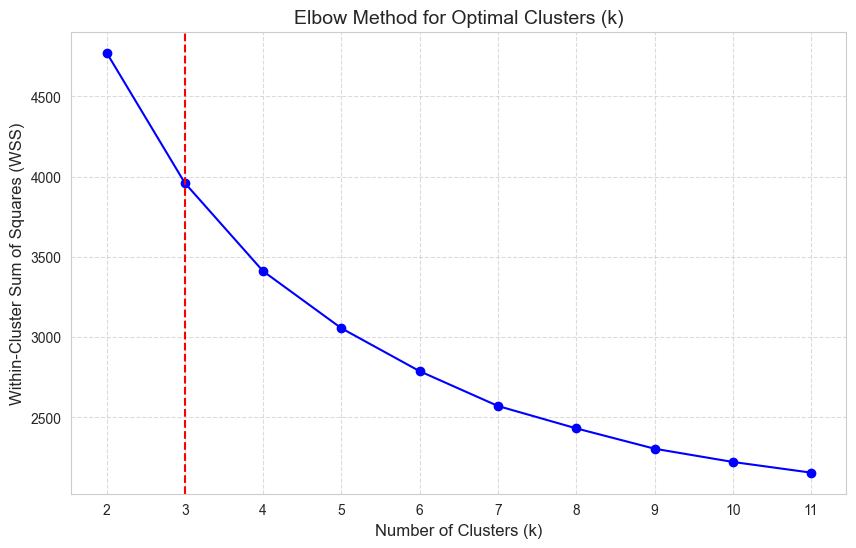

In [92]:
input = tracks[features]

# Apply PCA before clustering
# from sklearn.decomposition import PCA
# pca = PCA(n_components=3)
# pca_results = pca.fit_transform(tracks[features])
# tracks['PCA1'] = pca_results[:, 0]
# tracks['PCA2'] = pca_results[:, 1]
# tracks['PCA3'] = pca_results[:, 2]

# input = tracks[['PCA1','PCA2','PCA3']]

wss = []
k_range = range(2, 12)

for k in k_range:
    kmeans = KMeans(n_clusters = k, random_state = 42, n_init=10)
    kmeans.fit(input)
    wss.append(kmeans.inertia_)

# Assign clusters using k = 3

optimal_k = 3
kmeans = KMeans(n_clusters = optimal_k, random_state = 42, n_init=10)
cluster_labels = kmeans.fit_predict(input)
tracks['k_means_cluster'] = cluster_labels

k_means_cluster_counts = tracks.groupby('k_means_cluster')['track_id'].count().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(k_range, wss, marker='o', color='b', linestyle='-')
plt.title('Elbow Method for Optimal Clusters (k)', fontsize=14)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (WSS)', fontsize=12)
plt.axvline(x=optimal_k, color='r', linestyle='--')
plt.xticks(k_range)
plt.grid(True, linestyle='--', alpha=0.7)

plt.savefig('elbow_plot.png')

In [93]:
k_means_cluster_counts

,k_means_cluster,track_id
0,0,61
1,1,479
2,2,142


In [94]:
# Cluster Profile

# Apply both mean and std to every feature in the list
cluster_profile = tracks.groupby('k_means_cluster')[features].agg(['mean', 'std']).reset_index()
cluster_profile

k_means_cluster popularity           acousticness           danceability  \
                        mean       std         mean       std         mean   
0               0  -3.003929  0.813519    -0.488646  0.679856     0.762270   
1               1   0.213465  0.628998    -0.325343  0.665154     0.272324   
2               2  -1.035220  0.717359     1.742705  0.217018    -1.394263   

               energy           instrumentalness  ...  liveness            \
        std      mean       std             mean  ...      mean       std   
0  0.435651  0.344962  0.606834         1.597615  ... -0.147409  0.998088   
1  0.762261  0.363898  0.667913        -0.453668  ...  0.084423  1.004295   
2  0.647818 -1.755570  0.423369         1.650206  ... -0.390669  0.524759   

   loudness           speechiness               tempo             valence  \
       mean       std        mean       std      mean       std      mean   
0 -0.152445  0.437156    0.003397  0.707661  0.137938  0.168451 -0.665368   
1  0.386044  0.309558    0.148310  1.204986  0.046262  0.884348  0.233392   
2 -1.865954  1.004633   -0.430863  0.330574 -0.494278  1.194634 -0.943172   

             
        std  
0  0.854731  
1  0.894565  
2  0.668949  

[3 rows x 21 columns]

In [95]:
import seaborn as sns

## t-SNE plots to evaluate K-means

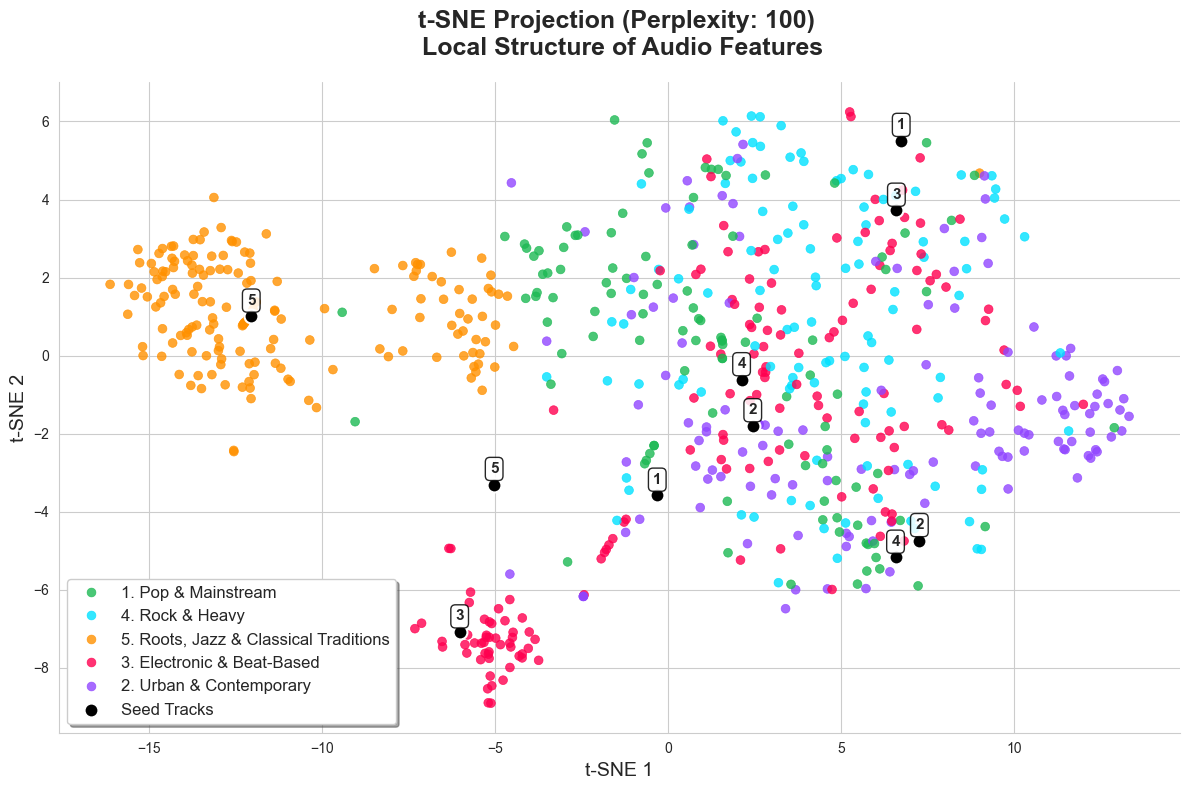

In [96]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Using a single perplexity as requested
p = 100
tsne = TSNE(n_components=2, perplexity=p, random_state=42, init='pca', learning_rate='auto')
tsne_results = tsne.fit_transform(tracks[features])

tracks['tsne-2d-one'] = tsne_results[:,0]
tracks['tsne-2d-two'] = tsne_results[:,1]

# Set whitegrid style for a cleaner background
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

# 1. Main Scatter Plot
ax = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="genre",
    palette=genre_color,
    data=tracks,
    alpha=0.8,
    s=40, # Slightly smaller points to reduce clutter
    edgecolor=None
)

# 2. Seed Tracks Overlay
seeds_to_label = tracks[tracks['track_id'].isin(seed_tracks['track_id'])]

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    data=seeds_to_label,
    color='black',
    s=100,         
    marker='o',   
    edgecolor='white',
    linewidth=1.5,
    label='Seed Tracks',
    zorder=5      
)

# 3. Enhanced Seed Labels
for i in range(len(seeds_to_label)):
    plt.text(
        x=seeds_to_label.iloc[i]['tsne-2d-one'],
        y=seeds_to_label.iloc[i]['tsne-2d-two'] + 0.3, # Increased offset for visibility
        s=seeds_to_label.iloc[i]['first_genre'], 
        fontsize=11, # Bigger font
        weight='bold',
        ha='center',
        bbox=dict(facecolor='white', alpha=0.85, edgecolor='black', boxstyle='round,pad=0.3'),
        zorder=10
    )

# 4. Refined Formatting
plt.title(f't-SNE Projection (Perplexity: {p}) \n Local Structure of Audio Features', fontsize=18, pad=20, weight='bold')
plt.xlabel('t-SNE 1', fontsize=14)
plt.ylabel('t-SNE 2', fontsize=14)

# Place Legend INSIDE (adjust loc as needed based on data distribution)
plt.legend(loc='lower left', fontsize=12, frameon=True, shadow=True)

# Remove the outer "box" for a modern look
sns.despine()

plt.tight_layout()
plt.show()

## PCA to visualize global distances

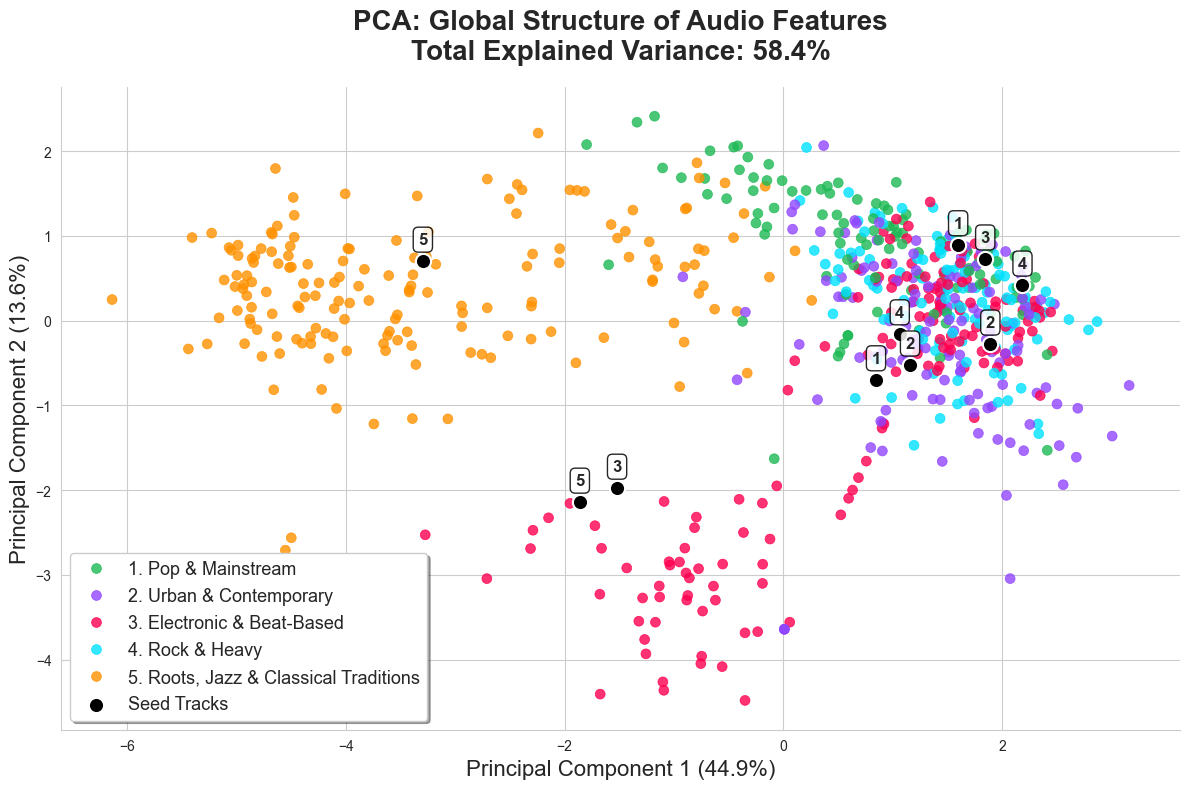

In [102]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Initialize and fit PCA
pca = PCA(n_components=2)
pca_results = pca.fit_transform(tracks[features])
tracks['pca-one'] = pca_results[:,0]
tracks['pca-two'] = pca_results[:,1]
exp_var = pca.explained_variance_ratio_

# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

# 2. Main Scatter Plot
ax = sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="genre",
    palette=genre_color,
    data=tracks,
    alpha=0.8,
    s=50,
    edgecolor=None
)

# 3. Overlay Seed Tracks
seeds_to_label = tracks[tracks['track_id'].isin(seed_tracks['track_id'])]

sns.scatterplot(
    x="pca-one", y="pca-two",
    data=seeds_to_label,
    color='black',
    s=120,         
    marker='o',   
    edgecolor='white',
    linewidth=1.5,
    label='Seed Tracks',
    zorder=5      
)

# 4. Enhanced Seed Labels
for i in range(len(seeds_to_label)):
    plt.text(
        x=seeds_to_label.iloc[i]['pca-one'],
        y=seeds_to_label.iloc[i]['pca-two'] + 0.2, # Adjust offset based on data scale
        s=seeds_to_label.iloc[i]['first_genre'], 
        fontsize=12,
        weight='bold',
        ha='center',
        bbox=dict(facecolor='white', alpha=0.85, edgecolor='black', boxstyle='round,pad=0.3'),
        zorder=10
    )

# 5. Formatting with Bigger Fonts
plt.title(f'PCA: Global Structure of Audio Features\nTotal Explained Variance: {sum(exp_var)*100:.1f}%', 
          fontsize=20, pad=20, weight='bold')
plt.xlabel(f'Principal Component 1 ({exp_var[0]*100:.1f}%)', fontsize=16)
plt.ylabel(f'Principal Component 2 ({exp_var[1]*100:.1f}%)', fontsize=16)

# --- REARRANGE LEGEND ALPHABETICALLY ---
handles, labels = ax.get_legend_handles_labels()

# Sort both lists by the label name
sorted_legend = sorted(zip(labels, handles), key=lambda x: x[0])
sorted_labels, sorted_handles = zip(*sorted_legend)

# Apply the sorted legend
plt.legend(
    sorted_handles, 
    sorted_labels, 
    loc='lower left', 
    fontsize=13, 
    frameon=True, 
    shadow=True, 
    title_fontsize=14
)

sns.despine()
plt.tight_layout()
plt.show()

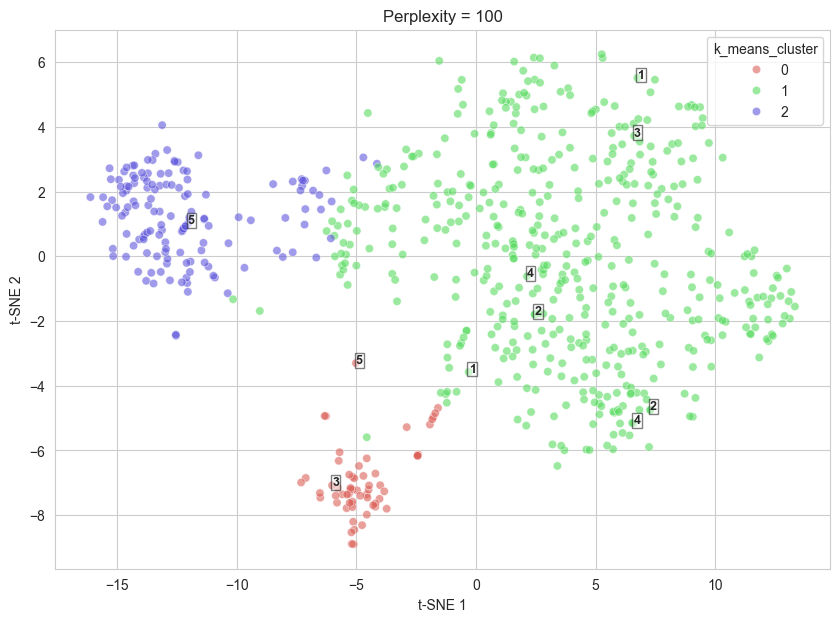

In [ ]:
from sklearn.manifold import TSNE

# comparison = range(20, 200, 20)
comparison = [100]

for p in comparison:
    tsne = TSNE(n_components=2, perplexity=p, random_state=42, init='pca', learning_rate='auto')
    tsne_results = tsne.fit_transform(tracks[features])

    # 4. Add results back to a temporary dataframe for plotting
    tracks['tsne-2d-one'] = tsne_results[:,0]
    tracks['tsne-2d-two'] = tsne_results[:,1]

    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="k_means_cluster",
        palette=sns.color_palette("hls", tracks['k_means_cluster'].nunique()),
        data=tracks,
        legend="full",
        alpha=0.6
    )

    seeds_to_label = tracks[tracks['track_id'].isin(seed_tracks['track_id'])]
    for i in range(len(seeds_to_label)):
        plt.text(
            x=seeds_to_label.iloc[i]['tsne-2d-one'],
            y=seeds_to_label.iloc[i]['tsne-2d-two'], 
            s=seeds_to_label.iloc[i]['first_genre'], 
            fontsize=9,
            weight='bold',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', pad=1) # Makes text readable
        )

    plt.title(f'Perplexity = {p}')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.show()

## K-means with seeded clusters

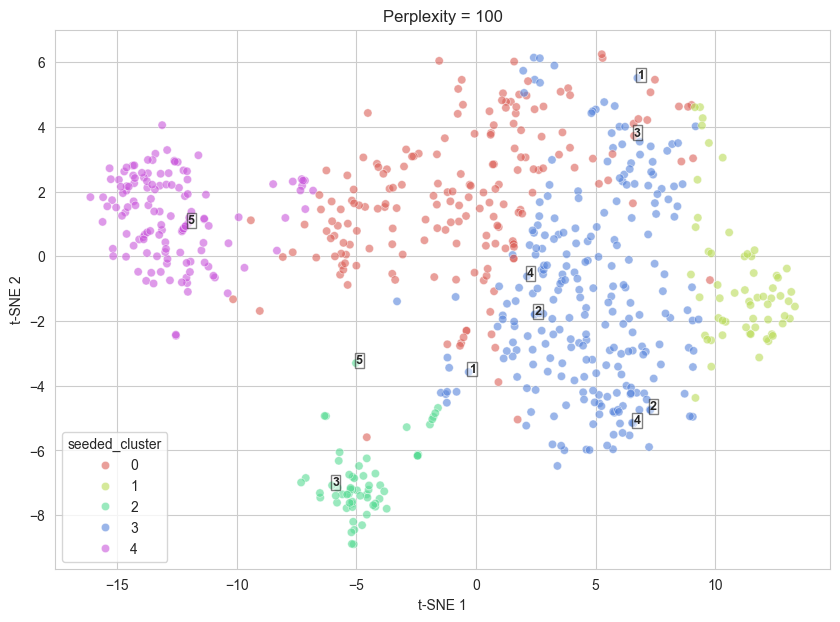

In [ ]:
from sklearn.manifold import TSNE

comparison = range(20, 200, 20)
comparison = [100]

for p in comparison:
    tsne = TSNE(n_components=2, perplexity=p, random_state=42, init='pca', learning_rate='auto')
    tsne_results = tsne.fit_transform(tracks[features])

    # 4. Add results back to a temporary dataframe for plotting
    tracks['tsne-2d-one'] = tsne_results[:,0]
    tracks['tsne-2d-two'] = tsne_results[:,1]

    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="seeded_cluster",
        palette=sns.color_palette("hls", tracks['seeded_cluster'].nunique()),
        data=tracks,
        legend="full",
        alpha=0.6
    )

    seeds_to_label = tracks[tracks['track_id'].isin(seed_tracks['track_id'])]
    for i in range(len(seeds_to_label)):
        plt.text(
            x=seeds_to_label.iloc[i]['tsne-2d-one'],
            y=seeds_to_label.iloc[i]['tsne-2d-two'], 
            s=seeds_to_label.iloc[i]['first_genre'], 
            fontsize=9,
            weight='bold',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', pad=1) # Makes text readable
        )

    plt.title(f'Perplexity = {p}')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.show()

In [ ]:
output = tracks[['track_id', 'track_name', 'first_genre', 'position', 'seeded_cluster', 'k_means_cluster'] + features]
output.to_csv('clustered_tracks.csv')